In [23]:
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap
from sklearn.metrics import  roc_auc_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import pickle

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

colors = ["#A115FE", "#8F00FF", "#29AB50", "#22753b", "#A015FE", "#8F00EF", "#ECE919", "#7a781d", "#0F91D0", "#0f3f75"]
sns.set_theme(rc={'figure.figsize':(12,12)})
sns.set_palette(sns.color_palette(colors))

In [24]:
# для локального открытия файла с данными
file_path = "Data/train_ai_comp_final_dp.parquet"
df = pd.read_parquet(file_path, engine='fastparquet').set_index('id', drop=True)

# для скачивания и открытия сырых данных с диска
#df = download_raw_data_from_drive_and_open_in_pandas()

In [25]:
target = df['target']

In [26]:
df.drop(['feature756', 'feature642'], axis=1, inplace=True)

In [27]:
df.drop(['target', 'sample_ml_new'], axis=1, inplace=True)

In [17]:
# найдем бинарные колонки
binar = list(df.columns[df.nunique() == 2])

cat_indexes = df[df.columns[~(df.nunique() == 2)]].nunique().div((df[df.columns[~(df.nunique() == 2)]] != 0).sum().values, axis=0) * 100 <= 0.15
potentially_categorical = set(cat_indexes[cat_indexes == True].index)

#potentially_categorical = binar.union(set(cat_indexes[cat_indexes == True].index))

# из потенциально категориальных попробуем вычесть колонки, которые могут быть численными
potentially_continuous = set(df.columns[df.isin([0]).any() & \
                                        df.isin([1]).any() & \
                                        df.isin([2]).any() & \
                                        df.isin([3]).any() & \
                                        df.isin([4]).any() & \
                                       (df.nunique() <= 500)])

cat_cols = potentially_categorical - potentially_continuous

In [18]:
cat_cols_final = cat_cols.difference(set(df.columns[(df.max() / df.quantile(q=0.9) < np.inf) & (df.max() / df.quantile(q=0.9) > 3)]))

In [19]:
columns = \
    ['feature1004',
    'feature341',
    'feature940',
    'feature319',
    'feature951',
    'feature988',
    'feature920',
    'feature444',
    'feature1',
    'feature909',
    'feature783',
    'feature782',
    'feature191',
    'feature907',
    'feature211',
    'feature342',
    'feature985',
    'feature94',
    'feature122',
    'feature209',
    'feature46',
    'feature900',
    'feature591',
    'feature454',
    'feature180',
    'feature989',
    'feature861',
    'feature1036',
    'feature470',
    'feature928',
    'feature898',
    'feature226',
    'feature25',
    'feature358',
    'feature446',
    'feature893',
    'feature551',
    'feature755',
    'feature572',
    'feature497',
    'feature930',
    'feature922',
    'feature472',
    'feature504',
    'feature688',
    'feature1075',
    'feature435',
    'feature141',
    'feature915',
    'feature540',
    'feature368',
    'feature459',
    'feature949',
    'feature316',
    'feature532',
    'feature817',
    'feature919',
    'feature29',
    'feature781',
    'feature287',
    'feature934',
    'feature1056',
    'feature89',
    'feature986',
    'feature491',
    'feature506',
    'feature489',
    'feature997',
    'feature340',
    'feature351',
    'feature182',
    'feature530',
    'feature715',
    'feature4',
    'feature918',
    'feature366',
    'feature854',
    'feature750',
    'feature917',
    'feature531',
    'feature554',
    'feature429',
    'feature405',
    'feature892',
    'feature335',
    'feature3',
    'feature286',
    'feature374',
    'feature777',
    'feature508',
    'feature488',
    'feature553',
    'feature810',
    'feature344',
    'feature154',
    'feature527',
    'feature820',
    'feature1045',
    'feature537',
    'feature856',
    'feature1065',
    'feature188',
    'feature535',
    'feature12',
    'feature1064',
    'feature932',
    'feature897',
    'feature452',
    'feature926',
    'feature829',
    'feature599',
    'feature1057',
    'feature393',
    'feature20']

In [20]:
def get_shap_feature(X_train, y_train, X_val, classifiers):
    import numpy as np
    import pandas as pd
    import shap

    # Список для хранения результатов по каждой модели
    models_shap_values = []

    for classifier in classifiers:
        classifier.fit(X_train, y_train)
        X_sample = shap.utils.sample(X_train, 10000)  # Выборка из 100 наблюдений
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_sample)

        # Создаем DataFrame с SHAP значениями и фильтруем значимые признаки
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'shap_importance': np.abs(shap_values).mean(axis=0)
        }).query("shap_importance > 0")

        # Усредняем оставшиеся SHAP значения для каждой фичи
        feature_importance = feature_importance.groupby('feature', as_index=False).mean()

        models_shap_values.append(feature_importance)

    # Объединяем SHAP значения из всех моделей
    final_shap_df = pd.concat(models_shap_values).groupby('feature', as_index=False).mean()

    return final_shap_df

X = df[columns]
y = target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

classifiers = [
    lgb.LGBMClassifier(n_estimators=50, random_state=42, max_depth=8, learning_rate=0.01),
    XGBClassifier(n_estimators=50, random_state=42, max_depth=8, learning_rate=0.01),
    CatBoostClassifier(iterations=50, learning_rate=0.01, depth=8, loss_function='Logloss', verbose=500)
]
shap_df = get_shap_feature(X_train, y_train, X_val, classifiers)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 16646, number of negative: 451007
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18964
[LightGBM] [Info] Number of data points in the train set: 467653, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035595 -> initscore=-3.299313
[LightGBM] [Info] Start training from score -3.299313


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


0:	learn: 0.6774883	total: 194ms	remaining: 9.51s
49:	learn: 0.2785772	total: 3.56s	remaining: 0us


In [21]:
def remove_highly_correlated_features(X_train, shap_df, threshold=0.9):
    import pandas as pd
    import numpy as np

    df_copy = X_train.copy()

    # Если размер данных больше 100000 строк, делаем выборку
    if len(df_copy) > 100000:
        df_sample = df_copy.sample(n=100000, random_state=1)
    else:
        df_sample = df_copy

    corr_matrix = df_sample.corr().abs()

    # Получаем пары фич с высокой корреляцией
    high_corr_var = np.where(corr_matrix > threshold)
    high_corr_var = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if
                     x != y and x < y]

    # Подготавливаем список фич для удаления
    features_to_remove = []

    for feature_a, feature_b in high_corr_var:
        # Получаем SHAP значения для каждой фичи
        shap_a = shap_df.loc[shap_df['feature'] == feature_a, 'shap_importance'].values[0]
        shap_b = shap_df.loc[shap_df['feature'] == feature_b, 'shap_importance'].values[0]

        # Удаляем фичу с меньшим SHAP значением
        if shap_a < shap_b:
            features_to_remove.append(feature_a)
        else:
            features_to_remove.append(feature_b)

    # Удаляем дубликаты в списке фич для удаления
    features_to_remove = list(set(features_to_remove))

    # Возвращаем обновлённый DataFrame без удалённых фич
    return features_to_remove

feature = shap_df["feature"].values
without_drop = shap_df.sort_values(by = "shap_importance", ascending = False)["feature"].head(10)
X_test, X_train, X_val = X_test[feature], X_train[feature], X_val[feature]
columns_to_remove = remove_highly_correlated_features(X_train.drop(columns=without_drop.values), shap_df, threshold=0.9)
X_train, X_val, X_test = X_train.drop(columns=columns_to_remove), X_val.drop(columns=columns_to_remove),  X_test.drop(columns=columns_to_remove)

category = cat_cols_final
cat_features = [feature for feature in category if feature in X_test.columns]

lgbm = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 81,
 'n_jobs': -1,
 'num_leaves': 160,
 'objective': None,
 'random_state': 9,
 'reg_alpha': 0.1,
 'reg_lambda': 0.01,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'auc',
 'gpu_use_dp': True,
 'device_type': 'cpu',
 'bagging_fraction': 0.5,
 'feature_fraction': 0.3,
 'min_sum_hessian_in_leaf': 68}

#params = {'num_iterations': 999, 'learning_rate': 0.08141778879314024, 'max_depth': 8, 'reg_lambda': 13.085427934255682, 'random_strength': 0.00024998050498273446}
model = lgb.LGBMClassifier(**lgbm)
model.fit(X_train, y_train, categorical_feature=cat_features)

y_val_pred = model.predict_proba(X_val)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]

predictions = np.where(y_test_pred > 0.05, 1, 0)

roc_auc_val = roc_auc_score(y_val, y_val_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)
print(f"roc-auc val {roc_auc_val}")
print(f"roc-auc test {roc_auc_test}")
print(classification_report(y_val, predictions))

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=68, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=68, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 16646, number of negative: 451007
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of te

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=68, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=68, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=68, min_child_weight=0.001 will be ignored. Curre

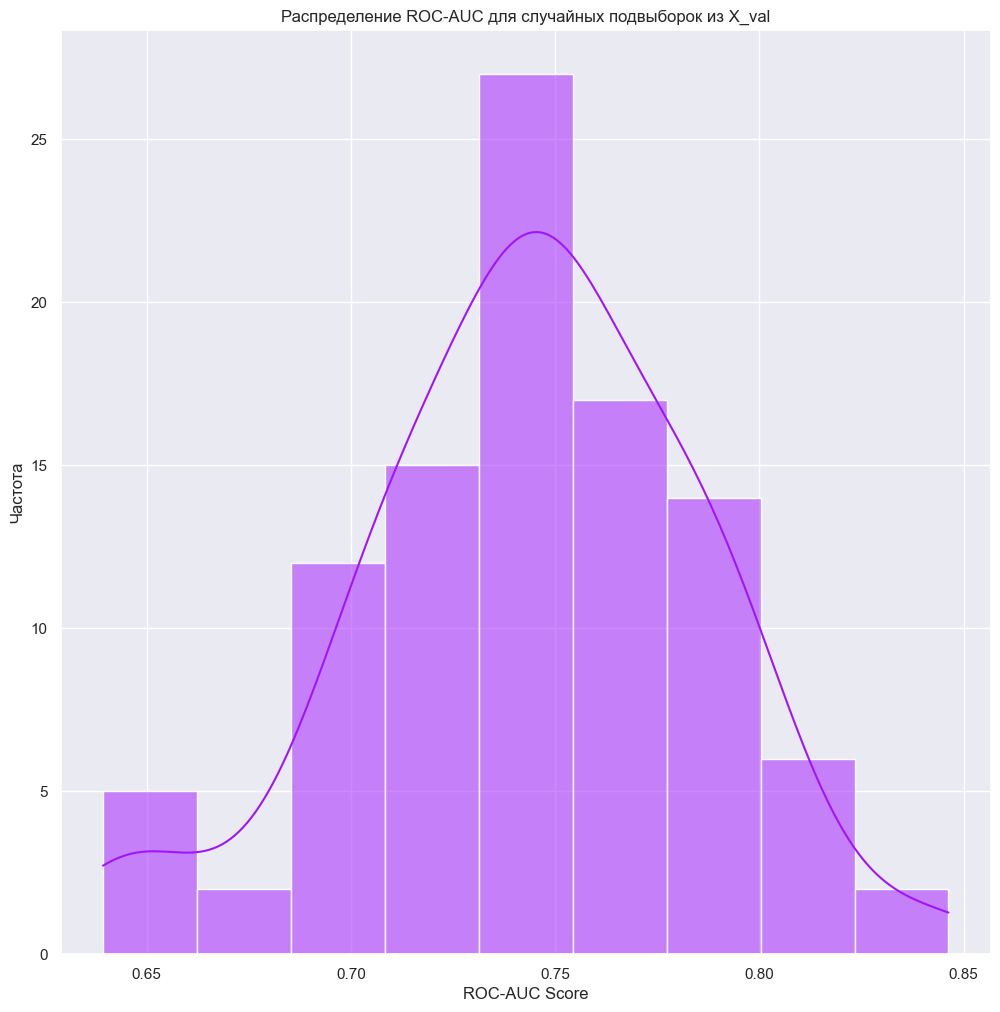

5-й квантиль: 0.6678067010309278
95-й квантиль: 0.8018013387587501


In [22]:
pickle.dump(model, open('model.pkl', 'wb'))

seed = 42
rng = np.random.RandomState(seed)

roc_auc_scores = []

for _ in range(100):  # Повторяем 100 раз
    # Выбираем случайные 1000 элементов из X_val и соответствующие метки y_val с помощью созданного генератора
    sample_indices = rng.choice(X_val.index, size=1000, replace=False)
    X_val_sample = X_val.loc[sample_indices]
    y_val_sample = y_val.loc[sample_indices]
    
    # Выполняем предсказание для выборки
    y_pred_sample = model.predict_proba(X_val_sample)[:, 1]
    
    # Вычисляем roc_auc и добавляем в список
    roc_auc = roc_auc_score(y_val_sample, y_pred_sample)
    roc_auc_scores.append(roc_auc)

# Визуализация распределения roc_auc с помощью гистограммы
sns.histplot(roc_auc_scores, kde=True)
plt.title('Распределение ROC-AUC для случайных подвыборок из X_val')
plt.xlabel('ROC-AUC Score')
plt.ylabel('Частота')
plt.show()

# Вычисление 5-го и 95-го квантилей
quantile_5 = np.percentile(roc_auc_scores, 5)
quantile_95 = np.percentile(roc_auc_scores, 95)

print(f"5-й квантиль: {quantile_5}")
print(f"95-й квантиль: {quantile_95}")